# Variational Autoencoder (VAE) 




In [1]:
## Import libraries
import numpy as np
import pandas as pd
import glob
from PIL import Image
from matplotlib.pyplot import imshow
import keras
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Input,Flatten,Lambda,Reshape,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

## Make function to load images, labels and paths
def get_images(path,resize = True):  
    img_array = []
    label_array=[]
    img_paths=[]
    fpaths = glob.glob(path, recursive=True)
    
    for fname in fpaths:
        img = Image.open(fname).convert('L')
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
        img_paths.append(fname)
        
        if 'good' in fname:
            label_array.append(0)
        else:
            label_array.append(1)
            
    paths=np.array(img_paths)
    images = np.array(img_array)
    labels= np.array(label_array)
    return images,labels,paths

In [2]:
## Import images from the local path.
path_train = r"C:/Users/polit/OneDrive/Desktop/MVtec/bottle/train/**/*.*"
path_test = r"C:/Users/polit/OneDrive/Desktop/MVtec/bottle/test/**/*.*"
path_cont_test = r"C:/Users/polit/OneDrive/Desktop/MVtec/bottle/test/contamination/*.*"
path_broken_large_test = r"C:/Users/polit/OneDrive/Desktop/MVtec/bottle/test/broken_large/*.*"

all_train,train_labels ,train_paths= get_images(path_train)
test ,test_labels,test_paths= get_images(path_test)
cont_test ,cont_test_labels,cont_test_paths= get_images(path_cont_test)
broken_large_test ,broken_large_test_labels,broken_large_test_paths= get_images(path_broken_large_test)

# Normalize image data
all_train = all_train.astype('float32') /255.
test = test.astype('float32') / 255.
cont_test = cont_test.astype('float32') / 255.
broken_large_test = broken_large_test.astype('float32') / 255.

# Split images for training and validation and Prepare for the variational autoencoder model
(train, val) = train_test_split(all_train, shuffle=False, train_size=0.8, random_state=1)
train = train.reshape(train.shape[0], train.shape[1], train.shape[2], 1)
val = val.reshape(val.shape[0], val.shape[1], val.shape[2], 1)
test = test.reshape(test.shape[0], test.shape[1], test.shape[2], 1)
cont_test = cont_test.reshape(cont_test.shape[0], cont_test.shape[1], cont_test.shape[2], 1)
broken_large_test = broken_large_test.reshape(broken_large_test.shape[0], broken_large_test.shape[1], broken_large_test.shape[2], 1)

In [3]:
# test_labels

In [4]:
# Lets define a Variational autoencoder model

# create a custom sampling layer with mean and variance
class Sampling_layer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        z_sigma = tf.exp(0.5 * z_log_var)

        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        return z_mean + z_sigma * epsilon
    
# Build vae which takes three variables
def building_vae(input_dim, filters, latent_dim):
    chan_dim = -1
    ## Lets define encoder
    inputs = layers.Input(shape=input_dim)
    # loop over the number of filters
    x = inputs
    for f in filters:
        x = layers.Conv2D(f, kernel_size=3, strides=2, padding="same")(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.LeakyReLU(alpha=0.1)(x)

    # get the image dimension of the last convolutional layer Which is required to build decoder
    conv_img_dim = K.int_shape(x)

    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)

    # Mean and variance for latent layers
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    # sampling layer that draws samples form mean and variance
    z = Sampling_layer()([z_mean, z_log_var])

    # build the encoder model that take two values inuts (= inputs) and output (=z)
    encoder = Model(inputs, z, name="encoder")

    ## decoder
    # start building the decoder model which will accept the
    # output of the encoder as its inputs
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(conv_img_dim[1:]), activation="relu")(latent_inputs)
    x = layers.Reshape((conv_img_dim[1], conv_img_dim[2], conv_img_dim[3]))(x)

    # loop over our number of filters, this time in reverse order
    for f in filters[::-1]:
        x = layers.Conv2DTranspose(f, kernel_size=3, strides=2, padding="same")(x)
#         x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        
    # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    depth = input_dim[2]
    x = layers.Conv2DTranspose(depth, kernel_size=3, padding="same")(x)
    outputs = layers.Activation("sigmoid")(x)
    
    # build the decoder model
    decoder = Model(latent_inputs, outputs, name="decoder")

    # build VAE, which is the encoder + decoder
    outputs = decoder(encoder(inputs))
    vae = Model(inputs, outputs, name="vae")

    # compute custom VAE loss
    reconstruction_loss = K.mean(K.sum(keras.losses.binary_crossentropy(inputs, outputs), 
                                       axis=(1, 2)))
    z_sigma = K.exp(0.5 * z_log_var)
    kl_loss = 1 + K.log(z_sigma) - K.square(z_mean) - z_sigma
    kl_loss = -0.5 * K.sum(kl_loss, axis=1)
    kl_loss = K.mean(kl_loss)

    vae_loss = reconstruction_loss+kl_loss

    # compile the model
    vae.add_loss(vae_loss)
    vae.compile(optimizer=keras.optimizers.Adam(lr=1e-4))

    # return a 3-tuple of the encoder, decoder, and vae
    return (encoder, decoder, vae)

### Build the model

In [5]:
# construct our Variational Autoencoder model
print("Building Variational Autoencoder...")
input_dim = train.shape[1:]
filters = (16,32, 32, 64, 64)
latent_dim = 4
(encoder, decoder, vae) = building_vae(input_dim, filters, latent_dim=latent_dim)

encoder.summary()
decoder.summary()
vae.summary()

Building Variational Autoencoder...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________

## Train the model

In [6]:
# initialize the number of epochs and batch size to train our model
EPOCHS = 100
BS = 16

History = vae.fit( train, train,
    validation_data=(val, val),
    epochs=EPOCHS,
    batch_size=BS)


Epoch 1/100
294/294 [==============================] - 20s 67ms/step - loss: 2351.2297 - val_loss: 1535.0491
Epoch 2/100
294/294 [==============================] - 19s 64ms/step - loss: 1270.7965 - val_loss: 1200.3300
Epoch 3/100
294/294 [==============================] - 19s 66ms/step - loss: 1199.6354 - val_loss: 1178.7700
Epoch 4/100
294/294 [==============================] - 19s 64ms/step - loss: 1185.7668 - val_loss: 1169.4315
Epoch 5/100
294/294 [==============================] - 18s 62ms/step - loss: 1178.6337 - val_loss: 1163.2433
Epoch 6/100
294/294 [==============================] - 18s 63ms/step - loss: 1173.9865 - val_loss: 1159.8127
Epoch 7/100
294/294 [==============================] - 19s 65ms/step - loss: 1170.3096 - val_loss: 1156.2015
Epoch 8/100
294/294 [==============================] - 19s 66ms/step - loss: 1167.7311 - val_loss: 1154.6604
Epoch 9/100
294/294 [==============================] - 19s 65ms/step - loss: 1165.8762 - val_loss: 1152.8223
Epoch 10/100
294/29

294/294 [==============================] - 19s 65ms/step - loss: 1150.0109 - val_loss: 1138.3621
Epoch 76/100
294/294 [==============================] - 19s 64ms/step - loss: 1150.0948 - val_loss: 1138.3417
Epoch 77/100
294/294 [==============================] - 19s 64ms/step - loss: 1149.8950 - val_loss: 1138.5577
Epoch 78/100
294/294 [==============================] - 19s 65ms/step - loss: 1149.9358 - val_loss: 1138.2037
Epoch 79/100
294/294 [==============================] - 20s 68ms/step - loss: 1149.8336 - val_loss: 1138.0181
Epoch 80/100
294/294 [==============================] - 21s 73ms/step - loss: 1149.6157 - val_loss: 1138.1067
Epoch 81/100
294/294 [==============================] - 21s 72ms/step - loss: 1149.6638 - val_loss: 1137.9052
Epoch 82/100
294/294 [==============================] - 20s 68ms/step - loss: 1149.5365 - val_loss: 1137.9678
Epoch 83/100
294/294 [==============================] - 22s 74ms/step - loss: 1149.6366 - val_loss: 1138.1077
Epoch 84/100
294/294 [=

## Check convergence 

<Figure size 432x288 with 0 Axes>

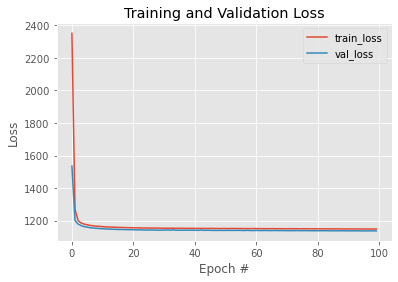

In [7]:
## Lets plot training loss and validation loss
plt.figure()
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
fig_plot = plt.figure()
plt.plot(N, History.history["loss"], label="train_loss")
plt.plot(N, History.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [28]:
# Define a function which calculates mean square error
def get_error(imgs_true, imgs_pred):
    return np.square(np.subtract(imgs_true, imgs_pred)).mean()
    
## Lets make empty lists to store mse for training, test and reconstruction images.          
train_pred = vae.predict(train)
mse_vector=[]
mse_vector_test=[]
mse_vector_cont_test=[]
mse_vector_broken_large_test = []
for i in range(train.shape[0]):
    mse_vector.append( get_error(train_pred[i], train[i]))

    
# Let us define the threshold value, below which images are normal and 
# after which images are anomaly
    
# threshold = np.quantile(mse_vector, 0.9)
threshold = np.mean(mse_vector)+0.25*np.std(mse_vector)

# threshold = np.mean(mse_vector)

test_pred = vae.predict(test)
cont_test_pred = vae.predict(cont_test)
broken_large_test_pred = vae.predict(broken_large_test)

for i in range(test.shape[0]):
    mse_vector_test.append( get_error(test_pred[i], test[i]))
test_anomaly = (mse_vector_test > threshold)
print(test_anomaly)

for i in range(cont_test.shape[0]):
    mse_vector_cont_test.append( get_error(cont_test_pred[i], cont_test[i]))
cont_test_anomaly = (mse_vector_cont_test > threshold)
print('cont_test_anomaly',cont_test_anomaly)

for i in range(broken_large_test.shape[0]):
    mse_vector_broken_large_test.append( get_error(broken_large_test_pred[i], broken_large_test[i]))
broken_large_test_anomaly = (mse_vector_broken_large_test > threshold)
print( '\n broken_large_test_anomaly',broken_large_test_anomaly)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False False  True False False False False False False]
cont_test_anomaly [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]

 broken_large_test_anomaly [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


(array([ 178.,  811., 1170., 1034.,  641.,  432.,  259.,  111.,   43.,
          15.]),
 array([0.00059437, 0.00083564, 0.00107692, 0.0013182 , 0.00155948,
        0.00180075, 0.00204203, 0.00228331, 0.00252458, 0.00276586,
        0.00300714], dtype=float32),
 <BarContainer object of 10 artists>)

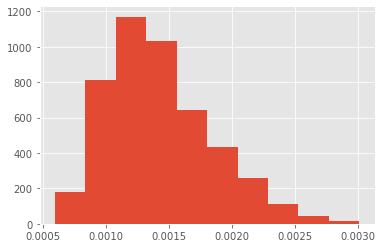

In [29]:
# Plot mse vector for normal images
plt.hist(mse_vector)

(array([20., 19., 20., 14.,  7.,  2.,  0.,  0.,  0.,  1.]),
 array([0.00068466, 0.00159378, 0.0025029 , 0.00341202, 0.00432114,
        0.00523027, 0.00613939, 0.00704851, 0.00795763, 0.00886675,
        0.00977587], dtype=float32),
 <BarContainer object of 10 artists>)

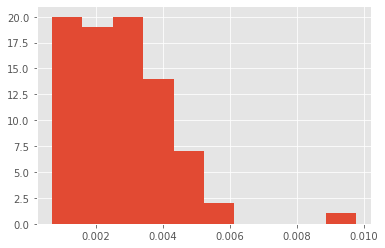

In [30]:
# Plot mse vector for test images
plt.hist(mse_vector_test)

(array([4., 7., 6., 2., 1., 0., 0., 0., 0., 1.]),
 array([0.00159115, 0.00262362, 0.00365609, 0.00468856, 0.00572103,
        0.00675349, 0.00778596, 0.00881843, 0.0098509 , 0.01088337,
        0.01191584], dtype=float32),
 <BarContainer object of 10 artists>)

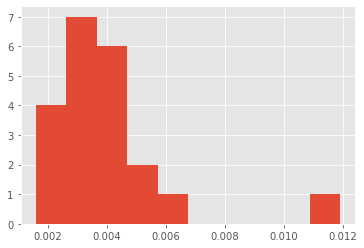

In [31]:
# Plot mse vector for contaminated images
plt.hist(mse_vector_cont_test)

(array([2., 3., 3., 3., 0., 4., 1., 2., 1., 1.]),
 array([0.00155814, 0.00188916, 0.00222019, 0.00255121, 0.00288223,
        0.00321325, 0.00354428, 0.0038753 , 0.00420632, 0.00453734,
        0.00486836], dtype=float32),
 <BarContainer object of 10 artists>)

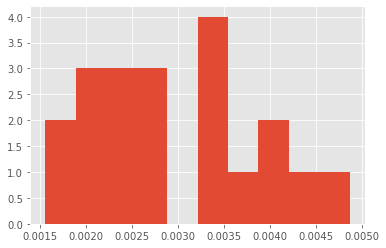

In [32]:
# Plot mse vector for broken large images
plt.hist(mse_vector_broken_large_test)

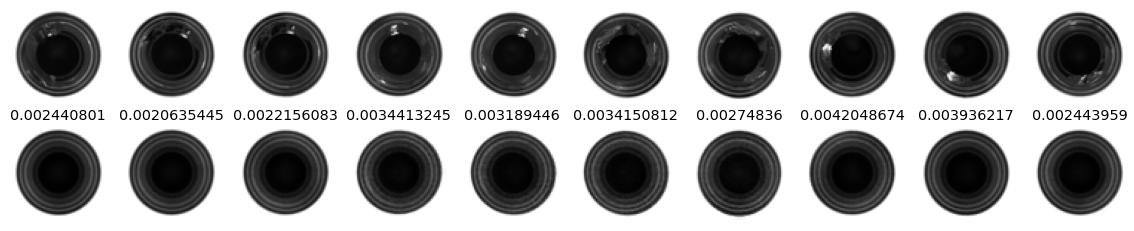

In [33]:
# Plot original and decoded images
decoded_imgs = vae.predict(test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test[i].reshape(64,64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64,64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(get_error(decoded_imgs[i], test[i]))
plt.show()

### Evaluation of model

In [34]:
# Accuracy of our model with test images

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
print("Accuracy = {}".format(accuracy_score(test_labels, test_anomaly)))
print("Precision = {}".format(precision_score(test_labels, test_anomaly)))
print("Recall = {}".format(recall_score(test_labels, test_anomaly)))
print( classification_report(test_labels, test_anomaly))

Accuracy = 0.9879518072289156
Precision = 0.984375
Recall = 1.0
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.98      1.00      0.99        63

    accuracy                           0.99        83
   macro avg       0.99      0.97      0.98        83
weighted avg       0.99      0.99      0.99        83



Text(0.5, 1.0, 'Confusion Matrix')

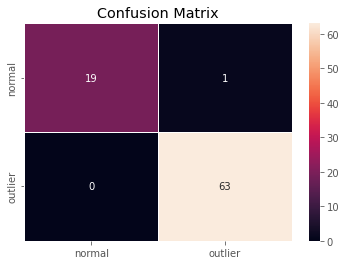

In [35]:
import seaborn as sns
labels = ['normal', 'outlier']
cm = confusion_matrix(test_labels, test_anomaly)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True,  cbar=True, linewidths=1)
plt.title("Confusion Matrix")

In [36]:
# Accuracy of our model with contaminated images

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
print("Accuracy = {}".format(accuracy_score(cont_test_labels, cont_test_anomaly)))
print("Precision = {}".format(precision_score(cont_test_labels, cont_test_anomaly)))
print("Recall = {}".format(recall_score(cont_test_labels, cont_test_anomaly)))
print( classification_report(cont_test_labels, cont_test_anomaly))

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [37]:
# Accuracy of our model with broken large images

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
print("Accuracy = {}".format(accuracy_score(broken_large_test_labels, broken_large_test_anomaly)))
print("Precision = {}".format(precision_score(broken_large_test_labels, broken_large_test_anomaly)))
print("Recall = {}".format(recall_score(broken_large_test_labels, broken_large_test_anomaly)))
print( classification_report(broken_large_test_labels, broken_large_test_anomaly))

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [38]:
# Make empty list of threshold value and store different values.
threshold_value = []
threshold1 = np.mean(mse_vector)
for i in range(0,20,2):
    threshold2 = threshold1 + i*0.05*np.std(mse_vector)
    threshold_value.append(threshold2)

# Check threshold values
threshold_value

[0.0014216896379366517,
 0.0014630999037763103,
 0.001504510169615969,
 0.0015459204354556278,
 0.0015873307012952865,
 0.001628740967134945,
 0.0016701512329746037,
 0.0017115614988142624,
 0.0017529717646539212,
 0.0017943820304935798]

In [39]:
# Make empty list of accuracy and append with accuries obtained by using different threshold values.
total_accuracy = []

for x in threshold_value:
    test_anomaly = (mse_vector_test > x)
    accuracy = accuracy_score(test_labels, test_anomaly)
    total_accuracy.append(accuracy)
    
# Check accuracies
total_accuracy

[0.9518072289156626,
 0.963855421686747,
 0.9879518072289156,
 0.9759036144578314,
 0.9759036144578314,
 0.963855421686747,
 0.927710843373494,
 0.927710843373494,
 0.9156626506024096,
 0.9156626506024096]

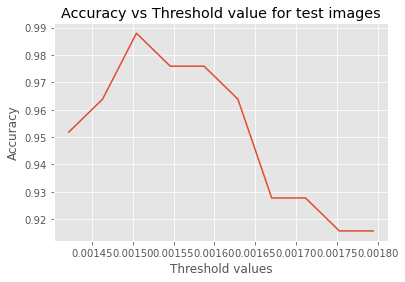

In [40]:
# Plot accuracy and threshold values
plt.plot(threshold_value, total_accuracy)
plt.title("Accuracy vs Threshold value for test images")
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.show()

In [41]:
# Check accuracy for contaminated images
total_accuracy1 = []

for x in threshold_value:
    test_anomaly1 = (mse_vector_cont_test > x)
    accuracy1 = accuracy_score(cont_test_labels, test_anomaly1)
    total_accuracy1.append(accuracy1)

# Accurecies for different threshold values.
total_accuracy1

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9047619047619048,
 0.9047619047619048,
 0.9047619047619048,
 0.9047619047619048,
 0.9047619047619048]

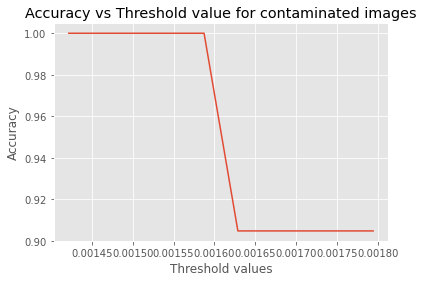

In [42]:
import matplotlib.pyplot as plt
plt.plot(threshold_value, total_accuracy1)
plt.title("Accuracy vs Threshold value for contaminated images")
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.show()

In [43]:
# Check accuracy for broken large images
total_accuracy2 = []

for x in threshold_value:
    test_anomaly2 = (mse_vector_broken_large_test > x)
    accuracy2 = accuracy_score(broken_large_test_labels, test_anomaly2)
    total_accuracy2.append(accuracy2)

# Accurecies for different threshold values.
total_accuracy2

[1.0, 1.0, 1.0, 1.0, 0.95, 0.95, 0.95, 0.95, 0.95, 0.9]

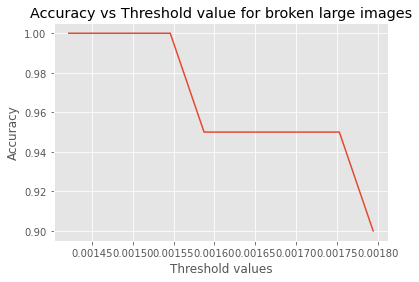

In [44]:
import matplotlib.pyplot as plt
plt.plot(threshold_value, total_accuracy2)
plt.title("Accuracy vs Threshold value for broken large images")
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.show()